# Image Segmentation Demo
Order of Operations for Image Segmentation


1. Preprocessing:
Noise Reduction: Apply filtering techniques (e.g., Gaussian blur) to remove noise from the image.
Intensity Normalization: Adjust the intensity levels to improve contrast and highlight features.
Resizing: Scale the image if necessary to a consistent size for further processing.

2. Feature Extraction:
Extract relevant features from the image that will help in distinguishing between different segments. This may include:
Color information (RGB, HSV)
Texture features (e.g., texture descriptors, edge detection)
Shape descriptors

3. Segmentation Method Selection:
Choose an appropriate segmentation method based on the specific application and characteristics of the images. Common methods include:
Thresholding
Region-based segmentation (e.g., region growing, merging)
Clustering-based methods (e.g., k-means, mean shift)
Edge detection methods (e.g., Canny edge detection)
Machine Learning / Deep Learning approaches (e.g., U-Net, Mask R-CNN)

4. Segmentation Execution:
Apply the selected segmentation algorithm to the preprocessed image to divide it into distinct segments or regions.


Our first step is to load the packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, feature, segmentation, color, restoration, filters, transform, measure, morphology, draw, exposure


## Example 1: Simple Image Operations

The idea is to think of an image as a matrix and find edge detections

## Example 2: Noise reduction / smoothing / thresholding

Next let's read our images:

(-0.5, 511.5, 511.5, -0.5)

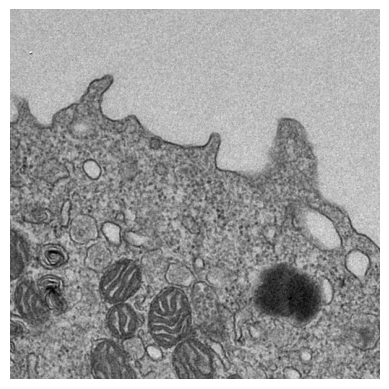

In [2]:
file_path = r'test_seg_images/k75Kf715A9h6p4S60682_2D_img02560-LOC-2d-0-512_1024-1536.tiff'
image = io.imread(file_path)
plt.imshow(image, cmap='gray')
plt.axis('off')

Look at Equalizing Gamma or Adaptive Equalization 

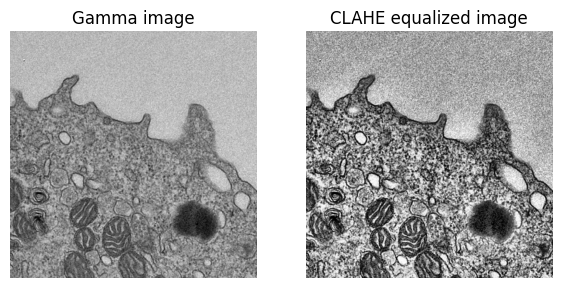

In [3]:
gamma_image = exposure.adjust_gamma(image, gamma=1, gain=1)
clahe_image = exposure.equalize_adapthist(image)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))

ax[0].imshow(gamma_image, cmap='gray')
ax[0].set_title('Gamma image')
ax[0].axis('off')

ax[1].imshow(clahe_image, cmap='gray')
ax[1].set_title('CLAHE equalized image')
ax[1].axis('off')
plt.subplots_adjust()
plt.show()

The gamma image looks to have identifiable levels - let's go with it.

Now let's apply Multi-threshold

(-0.5, 511.5, 511.5, -0.5)

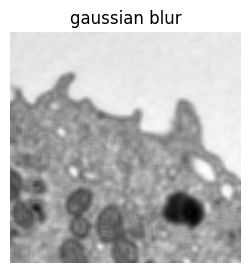

In [4]:
blur_image = filters.gaussian(gamma_image, sigma=31, truncate=1/5)
plt.figure(figsize=(4, 3))
plt.title('gaussian blur')
plt.imshow(blur_image, cmap='gray')
plt.axis('off')

We've smoothed out a lot of artifacts, now let's apply our multi-otsu threshold

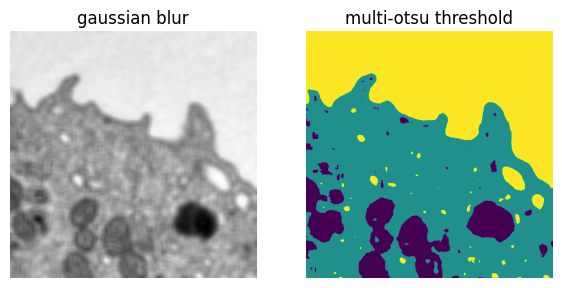

In [5]:
thresholds = filters.threshold_multiotsu(blur_image)
regions = np.digitize(blur_image, bins=thresholds)

# threshold_global_otsu = filters.threshold_otsu(blur_image)
# global_otsu_binary = blur_image >= threshold_global_otsu

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
ax[0].imshow(blur_image, cmap='gray')
ax[0].set_title('gaussian blur')
ax[0].axis('off')

ax[1].imshow(regions)
ax[1].set_title('multi-otsu threshold')
ax[1].axis('off')
plt.subplots_adjust()
plt.show()

There's a lot of small artifacts in the image so let's remove those

Also use normal otsu thresholding (binary) to remove the background.

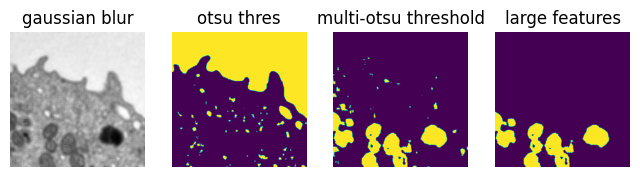

In [6]:
threshold_global_otsu = filters.threshold_otsu(blur_image)
global_otsu_binary = blur_image >= threshold_global_otsu

# we're only interested in the first region captured by the threshold
multi_otsu_regions = (regions == 0)

# Remove small artifacts
large_objects = morphology.remove_small_objects(multi_otsu_regions, min_size=500)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 4))
ax[0].imshow(blur_image, cmap='gray')
ax[0].set_title('gaussian blur')
ax[0].axis('off')

ax[1].imshow(global_otsu_binary)
ax[1].set_title('otsu thres')
ax[1].axis('off')

ax[2].imshow(multi_otsu_regions)
ax[2].set_title('multi-otsu threshold')
ax[2].axis('off')

ax[3].imshow(large_objects)
ax[3].set_title('large features')
ax[3].axis('off')
plt.subplots_adjust()
plt.show()

Now let's apply the mask to the original image

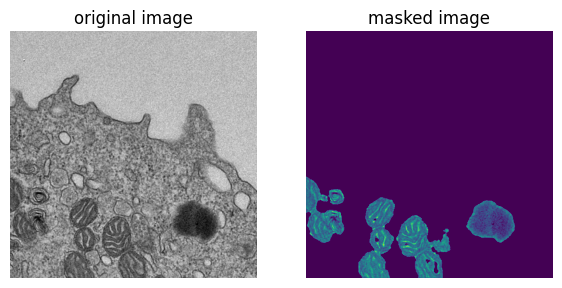

In [7]:
masked_image = image * (large_objects == 1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('original image')
ax[0].axis('off')

ax[1].imshow(masked_image)
ax[1].set_title('masked image')
ax[1].axis('off')
plt.subplots_adjust()
plt.show()

## Example 3

In this example let's utilize morphological operations

(-0.5, 511.5, 511.5, -0.5)

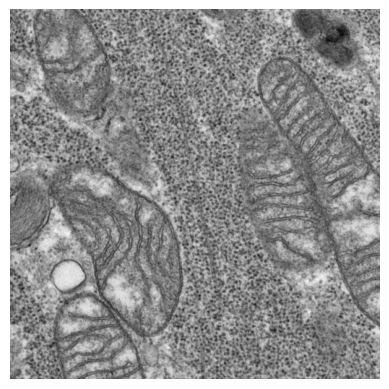

In [8]:
file_path = r'test_seg_images/73305IX3JqLNR72O9O46_2D_img01769-LOC-2d-1024-1536_1024-1536.tiff'
image = io.imread(file_path)
plt.imshow(image, cmap='gray')
plt.axis('off')

Clean the image

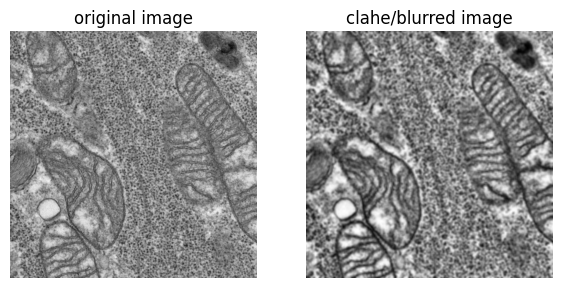

In [9]:
clahe_image = exposure.equalize_adapthist(image)
blur_image = filters.gaussian(clahe_image, sigma=11, truncate=1/5)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('original image')
ax[0].axis('off')

ax[1].imshow(blur_image, cmap='gray')
ax[1].set_title('clahe/blurred image')
ax[1].axis('off')
plt.subplots_adjust()
plt.show()

Lets apply multi-otsu to find the regions of interest.  Also let's remove small artifacts.

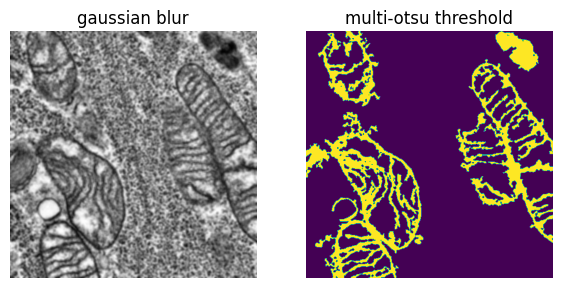

In [10]:
# Global Otsu - create mask on background
thresholds = filters.threshold_multiotsu(blur_image)
regions = np.digitize(blur_image, bins=thresholds)

multi_otsu_regions = (regions == 0)
large_objects = morphology.remove_small_objects(multi_otsu_regions, min_size=2000)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
ax[0].imshow(blur_image, cmap='gray')
ax[0].set_title('gaussian blur')
ax[0].axis('off')


ax[1].imshow(large_objects)
ax[1].set_title('multi-otsu threshold')
ax[1].axis('off')
plt.subplots_adjust()
plt.show()

Our mask is not closed in some regions, so let's apply dilations to cover the regions of interest.

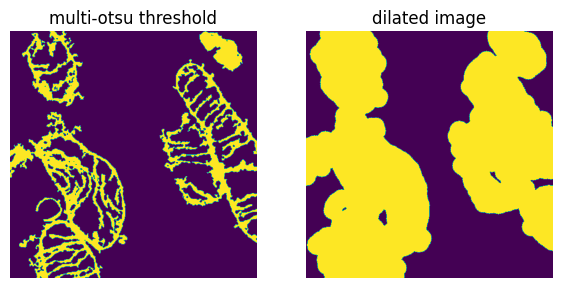

In [11]:
footprint = morphology.disk(17)
dilated_image = morphology.binary_dilation(large_objects, footprint)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
ax[0].imshow(large_objects)
ax[0].set_title('multi-otsu threshold')
ax[0].axis('off')


ax[1].imshow(dilated_image)
ax[1].set_title('dilated image')
ax[1].axis('off')
plt.subplots_adjust()
plt.show()

Now let's apply our mask to the original image:

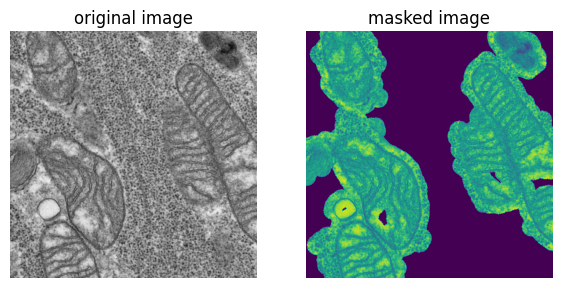

In [12]:
masked_image = image * (dilated_image == 1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('original image')
ax[0].axis('off')

ax[1].imshow(masked_image)
ax[1].set_title('masked image')
ax[1].axis('off')
plt.subplots_adjust()
plt.show()

## Example 4

Let's look at some advanced segmententing techniques from scikit learn and scikit-image.  

First let's examine Gaussian Mixture Model (GMM) segmentation.

First we read the image and both apply histogram equalization.

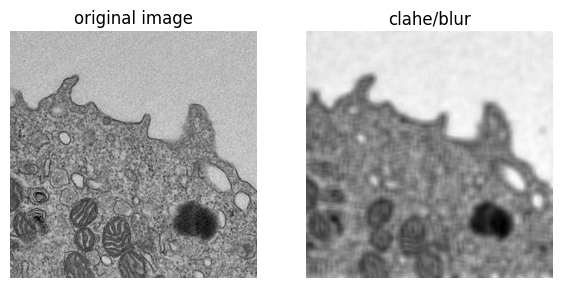

In [13]:
file_path = r'test_seg_images/k75Kf715A9h6p4S60682_2D_img02560-LOC-2d-0-512_1024-1536.tiff'

# Load and preprocess the image
image = io.imread(file_path)

clahe_image = exposure.equalize_adapthist(image, kernel_size=11, clip_limit=0.01) #contrast enhancement
blur_image = filters.gaussian(clahe_image, sigma=33, truncate=1/5)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('original image')
ax[0].axis('off')

ax[1].imshow(blur_image, cmap='gray')
ax[1].set_title('clahe/blur')
ax[1].axis('off')
plt.subplots_adjust()
plt.show()


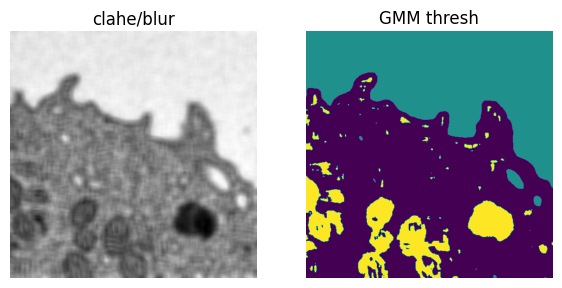

In [14]:
from sklearn.mixture import GaussianMixture

n_components = 3  # 3 classes for segmentation

rows, cols = np.shape(blur_image)

# reshape the image array to num_observations by num_features (1,000,000 by 3)
X = blur_image.reshape(-1,1)

# Create and train our Gaussian Mixture Expectation Maximization Model
model = GaussianMixture(n_components=3, tol=0.1)
model.fit(X)

# predict latent values
yhat = model.predict(X)

# reshape the result into an image
gmm_thresh = np.reshape(yhat,[rows,cols])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
ax[0].imshow(blur_image, cmap='gray')
ax[0].set_title('clahe/blur')
ax[0].axis('off')

ax[1].imshow(gmm_thresh)
ax[1].set_title('GMM thresh')
ax[1].axis('off')
plt.subplots_adjust()
plt.show()



# Example 5

Finally let's look at a really interesting new skimage algorithm called Weka Segmentation.

Read in our image and augment.


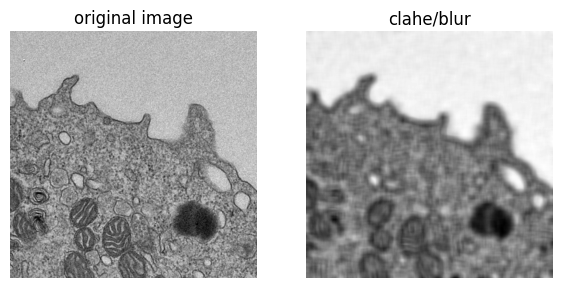

In [15]:
file_path = r'test_seg_images/k75Kf715A9h6p4S60682_2D_img02560-LOC-2d-0-512_1024-1536.tiff'
image = io.imread(file_path)
#equalize = exposure.equalize_hist(image) #contrast enhancement

clahe_image = exposure.equalize_adapthist(image, kernel_size=15, clip_limit=0.01) #contrast enhancement
blur_image = filters.gaussian(clahe_image, sigma=33, truncate=1/5)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('original image')
ax[0].axis('off')

ax[1].imshow(blur_image, cmap='gray')
ax[1].set_title('clahe/blur')
ax[1].axis('off')
plt.subplots_adjust()
plt.show()


Now let's assign dimensions to the regions of interest in the image we wish to segment

Text(0.5, 1.0, 'regions of interest')

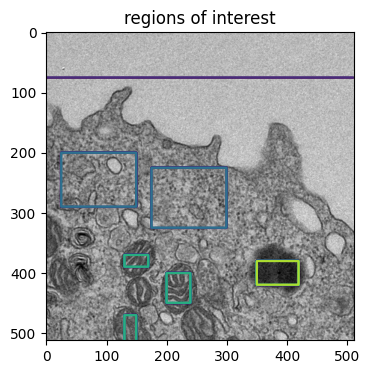

In [16]:
training_labels = np.zeros(blur_image.shape[:2], dtype=np.uint8)
training_labels[:75] = 1
training_labels[225:325, 175:300] = 2
training_labels[200:290, 25:150] = 2
training_labels[400:450, 200:240] = 3
training_labels[370:390, 130:170] = 3
training_labels[470:525, 130:150] = 3
training_labels[380:420, 350:420] = 4

fig = plt.figure(figsize=(7, 4))
plt.imshow(image, cmap='gray')
plt.contour(training_labels)
plt.title('regions of interest')


Now let's use our Random Forests Classifer to train on the ROIs

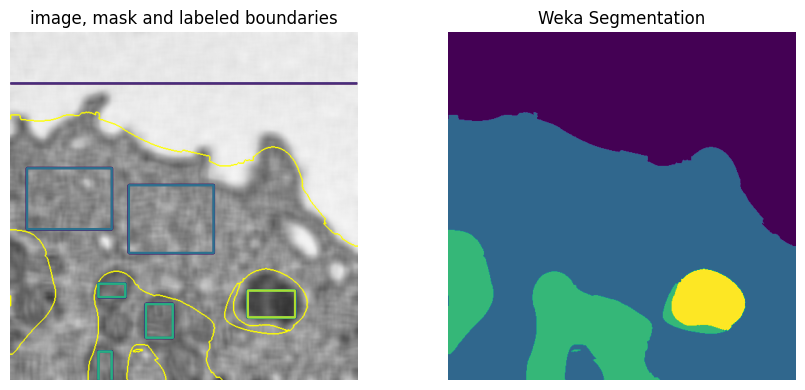

In [17]:
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from skimage import filters, segmentation, feature, future, io, exposure

sigma_min = 32
sigma_max = 64
features_func = partial(
    feature.multiscale_basic_features, #Intensity, gradient intensity and local structure are computed at different scales thanks to Gaussian blurring.
    intensity=True,
    edges=False,
    texture=True,
    sigma_min=sigma_min,
    sigma_max=sigma_max,
    channel_axis=None,
)
features = features_func(blur_image)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=100, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf) #Segmentation using labeled parts of the image and a classifier
result = future.predict_segmenter(features, clf)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(blur_image, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('image, mask and labeled boundaries')
ax[0].axis('off')

ax[1].imshow(result)
ax[1].set_title('Weka Segmentation')
ax[1].axis('off')

fig.tight_layout()